In [53]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'

#Dataset name
dataset = 'soil-sensor-readings-historical-data'
number_of_records = 100

# Add a filter for the number of results returned
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

soil_reading_url = f'{base_url}{dataset}/{filters}'
soil_reading_url

'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/soil-sensor-readings-historical-data/records?limit=100&offset=0&timezone=UTC'

In [14]:
# Use requests to get the data
result = requests.get(soil_reading_url)

In [15]:
result_json = result.json()
result_json.keys()

dict_keys(['total_count', 'links', 'records'])

In [16]:
result_json['total_count']

925030

In [17]:
records = result_json['records']

In [18]:
soil_df = pd.json_normalize(records)
soil_df.drop(columns = ['links'], inplace=True)

In [19]:
column_names = soil_df.columns.values.tolist()
column_names = [i.split('.')[-1] for i in column_names]
soil_df.columns = column_names
soil_df = soil_df.drop(columns = 'id')

In [20]:
soil_df

,timestamp,size,local_time,site_name,site_id,probe_id,probe_measure,soil_value,unit,json_featuretype
0,2023-09-01T07:08:46.91Z,127,2023-01-26T07:00:00+00:00,Natures Play,75500,1618813,Soil Moisture 60cm #0,51.93,%VWC,SoilSensorData
1,2023-09-01T07:08:46.91Z,145,2023-01-26T13:00:00+00:00,Princess bridge SW p10,101034,2019295,Soil Moisture 40cm (Adjusted),8.76,%VWC,SoilSensorData
2,2023-09-01T07:08:46.91Z,131,2023-01-26T13:00:00+00:00,Toms Block,66190,1338409,Soil Salinity 60cm #0,0.11,µS/cm,SoilSensorData
3,2023-09-01T07:08:46.91Z,134,2023-01-26T07:00:00+00:00,Fawkner North,75502,1618871,Soil Temperature 10cm #0,19.49,ºC,SoilSensorData
4,2023-09-01T07:08:46.91Z,146,2023-01-26T16:30:00+00:00,Princess bridge NE p11,101037,2019354,Soil Moisture 20cm (Adjusted),15.45,%VWC,SoilSensorData
...,...,...,...,...,...,...,...,...,...,...
95,2023-09-01T07:08:46.91Z,130,2023-01-26T17:00:00+00:00,Royal Parade CSIRO,88403,2031655,Soil Moisture 20cm,31.84,%VWC,SoilSensorData
96,2023-09-01T07:08:46.91Z,140,2023-01-26T11:00:00+00:00,Flagstaff Gardens 3,64991,1306549,Soil Salinity 30cm #0,0.22,µS/cm,SoilSensorData
97,2023-09-01T07:08:46.91Z,141,2023-01-26T11:30:00+00:00,Princess bridge NW p01,101032,2019262,Soil Temperature 10cm,18.47,ºC,SoilSensorData
98,2023-09-01T07:08:46.91Z,142,2023-01-26T17:00:00+00:00,Carlton Gardens North,64979,1306519,Soil Temperature 20cm #0,21.81,ºC,SoilSensorData


In [25]:
# Use links & iterate calls

def get_data(base, data_url, offset = 0):
    
    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    result_json = result.json()
    max_results = result_json['total_count']
    links = result_json['links']
    records = result_json['records']
    records_df = pd.json_normalize(records)
    
    # fix columns names
    records_df.drop(columns=['links'],inplace=True)
    column_names = records_df.columns.values.tolist()
    
    column_names = [i.split('.')[-1] for i in column_names]
    records_df.columns = column_names
    
    next_url = None
    
    # get next url
    if records_df.shape[0] != max_results:
        for l in links:
            if l['rel']=='next':
                next_url = l['href']
                
    return [records_df, next_url, column_names]

In [22]:
def add_to_dataframe(dataframe, new_data):
    df = pd.concat([dataframe, new_data])
    return df

In [30]:
def extract_dataframe(base_url, dataset):
    df_new, url_next, column_names = get_data(base_url, dataset)
    df = pd.DataFrame(columns=column_names)
    while url_next != None:
        df_new, url_next, column_names = get_data(base_url, dataset, df.shape[0])
        df = add_to_dataframe(df, df_new)
        if df.shape[0] == 9900:
            break
    return df

In [61]:
soil_df = extract_dataframe(base_url, dataset)

In [62]:
soil_df = soil_df.drop(columns = 'id')
soil_df

,timestamp,size,local_time,site_name,site_id,probe_id,probe_measure,soil_value,unit,json_featuretype
0,2023-09-01T07:08:46.91Z,127,2023-01-26T07:00:00+00:00,Natures Play,75500,1618813,Soil Moisture 60cm #0,51.93,%VWC,SoilSensorData
1,2023-09-01T07:08:46.91Z,145,2023-01-26T13:00:00+00:00,Princess bridge SW p10,101034,2019295,Soil Moisture 40cm (Adjusted),8.76,%VWC,SoilSensorData
2,2023-09-01T07:08:46.91Z,131,2023-01-26T13:00:00+00:00,Toms Block,66190,1338409,Soil Salinity 60cm #0,0.11,µS/cm,SoilSensorData
3,2023-09-01T07:08:46.91Z,134,2023-01-26T07:00:00+00:00,Fawkner North,75502,1618871,Soil Temperature 10cm #0,19.49,ºC,SoilSensorData
4,2023-09-01T07:08:46.91Z,146,2023-01-26T16:30:00+00:00,Princess bridge NE p11,101037,2019354,Soil Moisture 20cm (Adjusted),15.45,%VWC,SoilSensorData
...,...,...,...,...,...,...,...,...,...,...
95,2023-09-01T07:08:46.91Z,125,2023-01-16T17:00:00+00:00,Toms Block,66190,1338429,#0 Soil Moisture 80cm,27.67,%VWC,SoilSensorData
96,2023-09-01T07:08:46.91Z,147,2023-01-16T15:00:00+00:00,Alexandra Gardens Engineers Lawn,66195,1338752,#0 Soil Moisture 80cm,34.79,%VWC,SoilSensorData
97,2023-09-01T07:08:46.91Z,139,2023-01-16T11:00:00+00:00,Kings Domain North,66203,1338345,Soil Temperature 50cm #0,20.67,ºC,SoilSensorData
98,2023-09-01T07:08:46.91Z,128,2023-01-16T13:00:00+00:00,Argyle Square,64973,1304806,Soil Moisture 40cm #0,23.77,%VWC,SoilSensorData


In [44]:
soil_df['probe_measure'].unique()

array(['Soil Moisture 60cm #0', 'Soil Moisture 40cm (Adjusted)',
       'Soil Salinity 60cm #0', 'Soil Temperature 10cm #0',
       'Soil Moisture 20cm (Adjusted)', 'Soil Salinity 10cm',
       'Soil Moisture 20cm #0', 'Soil Moisture 10cm',
       'Soil Salinity 40cm #0', 'Soil Temperature 40cm',
       'Soil Salinity 70cm', 'Soil Temperature 30cm #0',
       'Soil Moisture 30cm (Adjusted)', 'Soil Moisture 30cm',
       'Soil Moisture 10cm #0', 'Soil Salinity 80cm #0',
       'Soil Salinity 70cm #0', 'Soil Moisture (Adjusted) 30cm',
       'Soil Moisture 10cm #0 (Sandy Loam)', 'Soil Temperature 70cm #0',
       'Soil Moisture 10cm #0 (Sand)', 'Soil Moisture 30cm #0',
       'Soil Temperature 80cm', 'Soil Moisture 20cm #0 (Clayey Loam)',
       'Soil Moisture 80cm #0', 'Soil Moisture 40cm #0',
       'Soil Moisture (Adjusted) 80cm', '#0 Soil Moisture 30cm',
       'Soil Moisture 70cm', 'Soil Temperature 30cm',
       'Soil Salinity 30cm', 'Soil Salinity 20cm #0',
       'Soil Salinity 3

In [80]:
moist_10 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 010cm']
moist_10 = moist_10.sort_values(by='local_time')
moist_10 = moist_10.head(12)

In [ ]:
moist_20 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 020cm']
moist_20 = moist_20.sort_values(by='local_time')
moist_20 = moist_20.head(11)

In [109]:
moist_30 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 030cm']
moist_30 = moist_30.sort_values(by='local_time')
moist_30 = moist_30.head(6)

In [111]:
moist_40 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 040cm']
moist_40 = moist_40.sort_values(by='local_time')
moist_40 = moist_40.head(12)

In [113]:
moist_50 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 050cm']
moist_50 = moist_50.sort_values(by='local_time')
moist_50 = moist_50.head(11)

In [115]:
moist_60 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 060cm']
moist_60 = moist_60.sort_values(by='local_time')
moist_60 = moist_60.head(5)

In [117]:
moist_70 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 070cm']
moist_70 = moist_70.sort_values(by='local_time')
moist_70 = moist_70.head(7)

In [119]:
moist_80 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 080cm']
moist_80 = moist_80.sort_values(by='local_time')
moist_80 = moist_80.head(6)

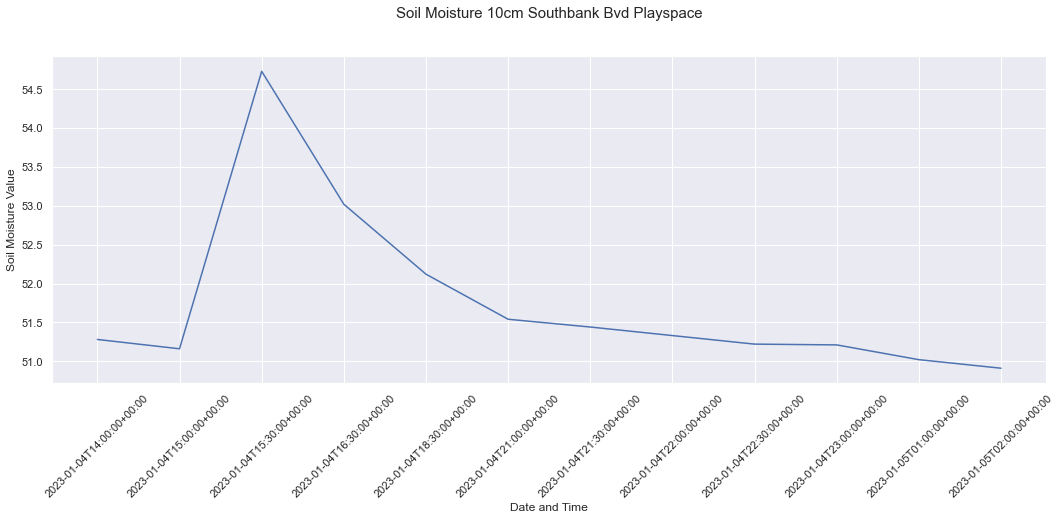

In [89]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(moist_10['local_time'], moist_10['soil_value'])

ax.set_xlabel("Date and Time")
ax.set_ylabel("Soil Moisture Value")
ax.set_title("Soil Moisture 10cm Southbank Bvd Playspace", y=1.1, fontsize=15)

ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

,timestamp,size,local_time,site_name,site_id,probe_id,probe_measure,soil_value,unit,json_featuretype
46,2023-09-01T07:08:46.91Z,136,2023-01-04T14:30:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.80,%VWC,SoilSensorData
57,2023-09-01T07:08:46.91Z,137,2023-01-04T15:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.83,%VWC,SoilSensorData
69,2023-09-01T07:08:46.91Z,137,2023-01-04T16:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,50.88,%VWC,SoilSensorData
74,2023-09-01T07:08:46.91Z,137,2023-01-04T18:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,50.25,%VWC,SoilSensorData
84,2023-09-01T07:08:46.91Z,136,2023-01-04T19:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,50.10,%VWC,SoilSensorData
36,2023-09-01T07:08:46.91Z,137,2023-01-04T22:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.85,%VWC,SoilSensorData
78,2023-09-01T07:08:46.91Z,137,2023-01-04T22:30:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.76,%VWC,SoilSensorData
42,2023-09-01T07:08:46.91Z,136,2023-01-04T23:30:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.60,%VWC,SoilSensorData
99,2023-09-01T07:08:46.91Z,137,2023-01-05T00:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.73,%VWC,SoilSensorData
73,2023-09-01T07:08:46.91Z,137,2023-01-05T00:30:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.59,%VWC,SoilSensorData
